# Practice 3 - Machine Translation with RNN

## 실습 3.1 - Text Classification with RNN model

### Dataset Load

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
with open('/content/drive/MyDrive/2024-1-nlp-3/Korean_movie_reviews_2016.txt/Korean_movie_reviews_2016.txt', encoding='utf-8') as f:
    docs = [doc.strip().split('\t') for doc in f]
    docs = [(doc[0], int(doc[1])) for doc in docs if len(doc) == 2]
    texts, labels = zip(*docs)

words_list = [doc.strip().split() for doc in texts]
print(words_list[:2])

[['부산', '행', '때문', '너무', '기대하고', '봤'], ['한국', '좀비', '영화', '어색하지', '않게', '만들어졌', '놀랍']]


### Dataset Preprocessing

In [3]:
total_words = []
for words in words_list:
    total_words.extend(words)

from collections import Counter
c = Counter(total_words)

max_features = 10000
common_words = [ word for word, count in c.most_common(max_features)]
# 빈도를 기준으로 상위 10000개의 단어들만 선택

# 각 단어에 대해서 index 생성하기
words_dic ={}
for index, word in enumerate(common_words):
    words_dic[word]=index+1

# 각 문서를 상위 10000개 단어들에 대해서 index 번호로 표현하기
filtered_indexed_words = []
for review in words_list:
    indexed_words=[]
    for word in review:
        try:
            indexed_words.append(words_dic[word])
        except:
            pass
    filtered_indexed_words.append(indexed_words)

### Dataset Loader for Model

In [4]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical


# X input padding
max_len = 40
X = sequence.pad_sequences(filtered_indexed_words, maxlen=max_len)

# y to one-hot category labeling
y_one_hot = to_categorical(labels)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2)

print(len(X_train))
print(len(X_test))

132307
33077


## Model Build
### 실습 문제 3.1.1 - Bidiricetional LSTM을 구현하여 모델링을 완성하시오
#### - from tensorflow.keras import layers 참고
#### - 모델링 -> 실습 2 참고
#### - https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional 참고

In [35]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()

model.add(layers.Embedding(max_features+1, 64, input_shape=(max_len,)))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 40, 64)            640064    
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 2)                 130       
                                                                 
Total params: 665026 (2.54 MB)
Trainable params: 665026 (2.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop

# early stopping 적용
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# local에 저장하고 싶을 경우 이용
#checkpoint_filepath = './temp/checkpoint_bi_lstm_kr'
#mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', save_weights_only=True, save_best_only=True)

# optimizer에 필요한 옵션 적용
# loss와 평가 metric 적용
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

### Training

In [8]:
history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.1, callbacks=[es])

Epoch 1/5
931/931 [==============================] - 53s 43ms/step - loss: 0.3440 - accuracy: 0.8385 - val_loss: 0.2599 - val_accuracy: 0.8923
Epoch 2/5
931/931 [==============================] - 16s 17ms/step - loss: 0.2488 - accuracy: 0.8993 - val_loss: 0.2573 - val_accuracy: 0.8975
Epoch 3/5
931/931 [==============================] - 16s 18ms/step - loss: 0.2297 - accuracy: 0.9083 - val_loss: 0.2439 - val_accuracy: 0.9008
Epoch 4/5
931/931 [==============================] - 15s 16ms/step - loss: 0.2165 - accuracy: 0.9141 - val_loss: 0.2411 - val_accuracy: 0.9005
Epoch 5/5
931/931 [==============================] - 16s 17ms/step - loss: 0.2053 - accuracy: 0.9196 - val_loss: 0.2377 - val_accuracy: 0.9014


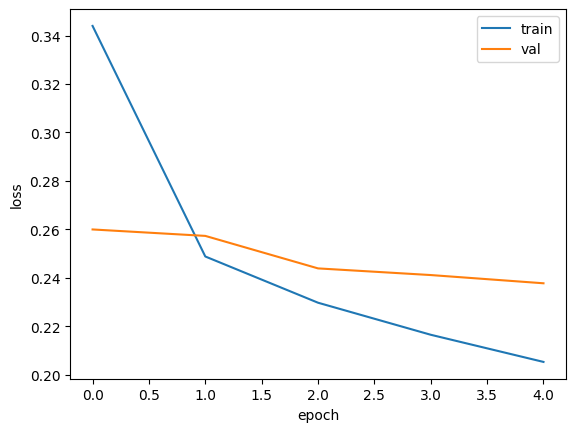

In [9]:
# Training history plot

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### Test

In [10]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Loss:", test_loss)
print("Accuracy:", test_acc)

1034/1034 [==============================] - 7s 6ms/step - loss: 0.2442 - accuracy: 0.8984
Loss: 0.24415920674800873
Accuracy: 0.8983584046363831


## 실습 3.2 - Machine Translation with Seq2Seq model

In [11]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

### Dataset Preprocessing

In [12]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # 단어와 단어 뒤에 오는 구두점(.)사이에 공백을 생성합니다.
    # 예시: "he is a boy." => "he is a boy ."
    # 참고:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # (a-z, A-Z, ".", "?", "!", ",")을 제외한 모든 것을 공백으로 대체합니다.
    # w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # 모델이 예측을 시작하거나 중단할 때를 알게 하기 위해서
    # 문장에 start와 end 토큰을 추가합니다.
    w = '<start> ' + w + ' <end>'
    return w

In [13]:
# 1. 문장에 있는 억양을 제거합니다.
# 2. 불필요한 문자를 제거하여 문장을 정리합니다.
# 3. 다음과 같은 형식으로 문장의 쌍을 반환합니다: [영어, 스페인어]
def create_dataset(path, num_examples):
    ens = []
    spas = []
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    for l in lines[:num_examples]:
        word_pairs = [preprocess_sentence(w) for w in l.split('\t')[:2]]
        en, spa = word_pairs
        ens.append(en)
        spas.append(spa)
    return ens, spas

path_to_file = '/content/drive/MyDrive/2024-1-nlp-3/spa-eng/spa.txt'
en, kor = create_dataset(path_to_file, None)

print(en[-1])
print(kor[-1])

print(len(en))
print(len(kor))

<start> one day , i woke up to find that god had put hair on my face . i shaved it off . the next day , i found that god had put it back on my face , so i shaved it off again . on the third day , when i found that god had put hair back on my face again , i decided to let god have his way . that's why i have a beard . <end>
<start> un dia , me desperte y vi que dios me habia puesto pelo en la cara . me lo afeite . al dia siguiente , vi que dios me lo habia vuelto a poner en la cara , asi que me lo afeite otra vez . al tercer dia , cuando vi que dios me habia puesto pelo en la cara de nuevo , decidi que dios se saliera con la suya . por eso tengo barba . <end>
141543
141543


### Tokenizing & Padding & Data Loading

In [14]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                           padding='post')
    return tensor, lang_tokenizer

In [15]:
def load_dataset(path, num_examples=None):
    # 전처리된 타겟 문장과 입력 문장 쌍을 생성합니다.
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [16]:
# 언어 데이터셋을 아래의 크기로 제한하여 훈련과 검증을 수행합니다.
num_examples = 10000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# 타겟 텐서와 입력 텐서의 최대 길이를 계산합니다.
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

# 훈련 집합과 검증 집합을 80대 20으로 분리합니다.
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 훈련 집합과 검증 집합의 데이터 크기를 출력합니다.
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

8000 8000 2000 2000


In [17]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
17 ----> se
1412 ----> quemo
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
8 ----> it
721 ----> burned
3 ----> .
2 ----> <end>


## Model Build for Training

In [18]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 128
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 512
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [19]:
# dataset 크기 출력
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([128, 13]), TensorShape([128, 8]))

## 인코더 모델과 디코더 모델 쓰기
어텐션(attention)을 가진 인코더-디코더 모델을 수행합니다. 어텐션(attention)은 TensorFlow Neural Machine Translation (seq2seq) tutorial에서 읽을 수 있습니다. 이 예제는 더 최신의 API 집합을 사용합니다. 이 노트북은 seq2seq 튜토리얼로부터 어텐션 방정식을 수행합니다. 아래의 다이어그램은 각각의 입력 단어가 어텐션 메커니즘에 의해 가중치가 할당된 모습입니다. 이러한 어텐션 메커니즘은 디코더가 문장에서 다음 단어를 예측하기 위해 사용됩니다. 아래의 그림과 공식은 Luong's paper에서 나온 어텐션 메커니즘의 예시입니다.

![image.png](attachment:c0952e5c-9c02-49c8-9117-f3fcf6b60447.png)![image.png](attachment:c0444d39-21a8-43e4-9792-86205b74b8ed.png)

이 튜토리얼은 인코더를 위해 Bahdanau 어텐션을 사용합니다. 단순화된 형태로 쓰기 전에 표기법을 아래와 같이 정의합니다:

FC = 완전 연결(Dense)층
EO = 인코더 결과
H = 은닉 상태(hidden state)
X = 디코더에 대한 입력
그리고 다음은 슈도코드입니다:

스코어(score)는 FC(tanh(FC(EO) + FC(H)))로 계산합니다.
어텐션 가중치는 softmax(score, axis = 1)로 계산합니다. 기본적으로 소프트맥스는 마지막 축을 적용하지만 스코어(score)의 형태가 (batch_size, max_length, hidden_size)이기 때문에 첫번째 축을 적용합니다. Max_length은 입력의 길이입니다. 각각의 입력에 가중치를 할당하려고 시도하기 때문에 소프트맥스는 그 축을 적용할 수 있습니다.
컨텍스트 벡터(context vector)는 sum(어텐션 가중치 * EO, axis = 1)로 계산합니다. 위와 같은 이유로 첫번째 축을 선택합니다.
임베딩 결과(embedding output)는 디코더 X에 대한 입력이 임베딩층을 통과한 결과입니다.
병합된 벡터(merged vector)는 concat(임베딩 결과, 컨텍스트 백터(context vector))와 같습니다.
그런 다음 병합된 벡터는 GRU에 주어집니다.

### 실습 문제 3.2.1 - Encoder & Attention & Decoder 각 Class 이해하고 주석 달기

In [20]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        # 배치 크기와 은닉 상태 크기를 설정합니다.
        # 입력 토큰을 벡터로 변환하는 임베딩 레이어를 설정합니다.
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # GRU 레이어를 설정합니다. 이 레이어는 시퀀스를 처리하고 인코더 상태를 반환합니다.
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        # 입력을 임베딩 레이어에 통과시킵니다.
        x = self.embedding(x)
        # 임베딩된 입력을 GRU에 통과시킵니다.
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self):
        # 숨겨진 상태를 0으로 초기화합니다.
        return tf.zeros((self.batch_sz, self.enc_units))

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        # 어텐션 가중치를 계산하는데 사용되는 완전 연결 레이어들을 설정합니다.
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # 어텐션 점수를 계산합니다.
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))
        # 소프트맥스를 적용하여 어텐션 가중치를 계산합니다.
        attention_weights = tf.nn.softmax(score, axis=1)
        # 가중 평균을 계산하여 컨텍스트 벡터를 생성합니다.
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        # 배치 크기와 디코더의 은닉 상태 크기를 설정합니다.
        # 목표 토큰을 임베딩하는데 사용되는 임베딩 레이어를 설정합니다.
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # 디코더 입력 및 컨텍스트 벡터를 처리하는데 사용되는 GRU 레이어를 설정합니다.
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        # 출력 로짓을 생성하기 위한 완전 연결 레이어를 설정합니다.
        self.fc = tf.keras.layers.Dense(vocab_size)
        # 어텐션 메커니즘을 설정합니다.
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # 컨텍스트 벡터와 어텐션 가중치를 계산합니다.
        context_vector, attention_weights = self.attention(hidden, enc_output)
        # 목표 토큰을 임베딩 레이어에 통과시킵니다.
        x = self.embedding(x)
        # 컨텍스트 벡터와 임베딩된 입력을 연결합니다.
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # 연결된 벡터를 GRU에 통과시킵니다.
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        # 출력 로짓을 생성합니다.
        x = self.fc(output)
        return x, state, attention_weights


### Encoder-Attention-Decoder 구현

In [21]:
# encoder
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# 샘플 입력
sample_hidden = encoder.initialize_hidden_state()  # encoder의 초기 hidden state 설정합니다.
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)  # encoder를 통해 입력 batch 처리합니다.
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))  # encoder 출력 shape 출력합니다.
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))  # encoder 최종 hidden state의 shape 출력합니다.

# encoder-decoder attention
attention_layer = BahdanauAttention(10)  # BahdanauAttention 객체 생성, attention units는 10으로 설정합니다.
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)  # attention 과 weights 계산합니다.

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))  # attention shape 출력합니다.
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))  # attention 가중치의 shape 출력합니다.

# decoder
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)  # Decoder 객체를 생성합니다.

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)  # decoder를 통해 샘플 입력 처리합니다.

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))  # decoder 출력 shape 출력합니다.


Encoder output shape: (batch size, sequence length, units) (128, 13, 1024)
Encoder Hidden state shape: (batch size, units) (128, 1024)
Attention result shape: (batch size, units) (128, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (128, 13, 1)
Decoder output shape: (batch_size, vocab size) (128, 2263)


### Training Setup

In [22]:
optimizer = tf.keras.optimizers.AdamW(lr=0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Training!

언어 모델 훈련하기
1. 인코더 결과와 인코더 은닉 상태(hidden state)를 반환하는 인코더를 통해서 입력을 전달합니다.
2. 인코더 결과, 인코더 은닉 상태(hidden state), 디코더 입력 (start 토큰)을 디코더에 전달합니다.
3. 전달 받은 값을 통해 디코더는 예측 값과 디코더 은닉 상태(hidden state)를 반환합니다.
4. 그 다음에 디코더 은닉 상태(hidden state)가 다시 모델에 전달되고 예측 값을 사용하여 손실을 계산합니다.
5. 디코더에 대한 다음 입력을 결정하기 위해서 교사 강요(teacher forcing)를 사용합니다.
6. 교사 강요(teacher forcing)는 타겟 단어가 디코더에 다음 입력으로 전달하기 위한 기술입니다.
7. 마지막 단계는 그레디언트(gradients)를 계산하여 이를 옵티마이저(optimizer)와 역전파(backpropagate)에 적용합니다.

In [23]:
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        # encoder
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden

        # decoder
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # 교사 강요(teacher forcing) - 다음 입력으로 타겟을 피딩(feeding)합니다.
        for t in range(1, targ.shape[1]):
            # enc_output를 디코더에 전달합니다.
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)

            # 교사 강요(teacher forcing)를 사용합니다.
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [24]:
# 이 파트가 매우 오래걸림

EPOCHS = 5

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} / Batch {} / Loss {:.4f} / Time taken {} sec'.format(epoch + 1,
                                                                                 batch,
                                                                                 batch_loss.numpy(),
                                                                                 time.time() - start))
    # 에포크가 2번 실행될때마다 모델 저장 (체크포인트)
    #if (epoch + 1) % 2 == 0:
    #    checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} / Loss {:.4f}'.format(epoch + 1,
                                          total_loss / steps_per_epoch))
    print('Time taken for {} epoch {} sec\n'.format(epoch + 1,
                                                    time.time() - start))

Epoch 1 / Batch 0 / Loss 4.5792 / Time taken 3.9370551109313965 sec
Epoch 1 / Loss 2.1994
Time taken for 1 epoch 30.534836292266846 sec

Epoch 2 / Batch 0 / Loss 1.6409 / Time taken 0.3307065963745117 sec
Epoch 2 / Loss 1.4925
Time taken for 2 epoch 21.68673038482666 sec

Epoch 3 / Batch 0 / Loss 1.2420 / Time taken 0.33178091049194336 sec
Epoch 3 / Loss 1.1105
Time taken for 3 epoch 20.57959222793579 sec

Epoch 4 / Batch 0 / Loss 0.7990 / Time taken 0.3283991813659668 sec
Epoch 4 / Loss 0.7858
Time taken for 4 epoch 40.94848132133484 sec

Epoch 5 / Batch 0 / Loss 0.5352 / Time taken 0.5177557468414307 sec
Epoch 5 / Loss 0.5237
Time taken for 5 epoch 20.975592851638794 sec



In [25]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 나중에 어텐션 가중치를 시각화하기 위해 어텐션 가중치를 저장합니다.
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 예측된 ID를 모델에 다시 피드합니다.
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [26]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

In [27]:
translate(u'hace mucho frio aqui.')

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it's too here . <end> 


### 실습 문제 3.2.2 - BLEU 스코어 구현하기
#### - Dataset Sample에서 Test 만들기
#### - BLEU Score 구현
#### - 학습된 모델로 BLEU Score로 평가하기

In [34]:
# 데이터 셋의 10프로를 테스트 셋으로 설정
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

In [33]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

#BLEU Score
def bleu_score(references, candidates):
    smoothie = SmoothingFunction().method4
    bleu_scores = []
    for ref, cand in zip(references, candidates):
        ref_tokens = ref.split()
        cand_tokens = cand.split()
        bleu_scores.append(
            corpus_bleu([[ref_tokens]], [cand_tokens], weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
        )
    return sum(bleu_scores) / len(bleu_scores)
predictions = []
references = []
for input_seq, target_seq in zip(input_tensor_test, target_tensor_test):
    prediction, _, _ = evaluate(inp_lang.sequences_to_texts([input_seq])[0])
    target = targ_lang.sequences_to_texts([target_seq])[0]
    predictions.append(prediction)
    references.append(target)
bleu_score = bleu_score(references, predictions)
print(f"BLEU Score: {bleu_score}")

BLEU Score: 0.242971150164143


### 실습 문제 3.2.3 - Hyperparmeter 튜닝으로 번역 성능 높이기
#### - 어떤 방안을 활용해 성능을 높였는지?
#### - 성능이 정량적으로 얼마나 높아졌는지?

In [30]:
# your code here